# Example script to generate text from Gutenberg.org texts
### Dr. Tirthajyoti Sarkar, Fremont, CA

This LSTM text-generation script was trained on Charles Dickens' "The Great Expectation" text from Gutenberg project.
The link to the text file: http://www.gutenberg.org/files/1400/1400-0.txt

It is recommended to run this script on GPU, as recurrent networks are quite computationally intensive.
If you try this script on new data, make sure your corpus has at least ~100k characters. ~1M is better.

In [20]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

### Get the corpus from the internet (or some server or local disk)

In [2]:
path = get_file(
    'Great-expectations.txt',
    origin='http://www.gutenberg.org/files/1400/1400-0.txt')
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length:', len(text))

1056768/1049619 [==============================] - 0s 0us/step
corpus length: 1013445


### Process the text, create short sequences of chosen length

In [3]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 62


In [62]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 100
step = 5
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 202669


### Vectorize the sequences for feeding to the neural network

In [119]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


### Build the LSTM model with two layers of 128 neurons each
We are using `RMSprop` optimizer with a rather high learning rate of 0.01. Please play with these options as you see fit.

In [120]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [121]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 100, 128)          97792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 62)                7998      
Total params: 237,374
Trainable params: 237,374
Non-trainable params: 0
_________________________________________________________________


### Random sampling function for introducing diversity in the choice of the character for generating text

In [122]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Set the length of the text to be generated

In [123]:
text_length = 200

### An empty dictionary to store the generated text

In [124]:
store = {}

### Callback function for `on_epoch_end`

In [125]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    print('-'*100)
    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.5]:
        print('----- diversity:', diversity)
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        #sys.stdout.write(generated)
        vector=[]
        for i in range(text_length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            #sys.stdout.write(next_char)
            vector.append(next_char)
            #sys.stdout.flush()
        print("-"*100)
        #print("SENTENCE:",sentence)
        #print("-"*100)
        print("GENERATED", ''.join(vector))
        store['Epoch_'+str(epoch)]=''.join(vector)
        print()

### Setting the `LambdaCallback`

In [126]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

### Choose the batch size and the number of epochs
Each epoch training took ~ 9-10 minutes on my modest laptop with NVidia GTX 1060 Ti GPU (6 GB Video RAM), Core i-7 8770 CPU, 16 GB DDR4.

In [129]:
batch_size = 128
epochs = 50

In [130]:
model.fit(x, y,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[print_callback])

Epoch 1/50
202669/202669 [==============================] - 543s 3ms/step - loss: 2.0212

----- Generating text after Epoch: 0
----------------------------------------------------------------------------------------------------
----- diversity: 0.5
----- Generating with seed: "me hour.

next day i set myself to get the boat. it was soon done, and the boat
was brought round to"
----------------------------------------------------------------------------------------------------
GENERATED  my and betword and and no meren and of the bre and herbert have her of the dorning the toods of assice and and alwer have have soon in the want and look of a roon of her sece of the groom and and all

Epoch 2/50
202669/202669 [==============================] - 539s 3ms/step - loss: 1.6671

----- Generating text after Epoch: 1
----------------------------------------------------------------------------------------------------
----- diversity: 0.5
----- Generating with seed: "er hair, and she had bridal f

c:\users\tirth\docume~1\personal\datasc~2\python~1\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


----------------------------------------------------------------------------------------------------
GENERATED  house, i had not you done this you say to a was a straight,” said mr. jaggers. i saw i had said to reads had been the stairs of the simpont into the own the first to be secourd was started in the fir

Epoch 7/50
202669/202669 [==============================] - 540s 3ms/step - loss: 1.4890

----- Generating text after Epoch: 6
----------------------------------------------------------------------------------------------------
----- diversity: 0.5
----- Generating with seed: "t the hour and minute,” said herbert, nodding, “at which she
afterwards stopped all the clocks. what"
----------------------------------------------------------------------------------------------------
GENERATED  i was the considered to the most late and that i was an at the breaking in the still and a fromes of the form of the part of the raing of good. “i am the window out, and i should be back with the

### The loss vs. epoch

We will see that loss suddenly goes up after 45 or so epochs. This is a stability problem with complex LSTM models. Model architecture and hyperparameter tuning is needed to continue improving the result.

In [131]:
import matplotlib.pyplot as plt

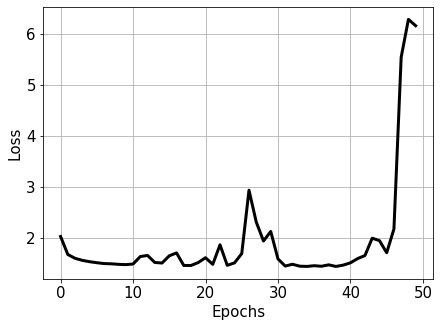

In [138]:
plt.figure(figsize=(7,5))
plt.plot(model.history.history['loss'],lw=3,c='k')
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.show()

### Some example generated texts

In [142]:
# The first 3 phrases
for i in range(3):
    print()
    print("PHRASE NO. {}".format(i+1))
    print("-"*60)
    print(store['Epoch_'+str(i)])
    print("="*100)


PHRASE NO. 1
------------------------------------------------------------
 my and betword and and no meren and of the bre and herbert have her of the dorning the toods of assice and and alwer have have soon in the want and look of a roon of her sece of the groom and and all

PHRASE NO. 2
------------------------------------------------------------
 to a boy, that i had be did and she was priding the sempled, and so this sain of the wears, that i was of path to hand the shrates, and but the sever to she would she had she was
and some the was
lon

PHRASE NO. 3
------------------------------------------------------------
r the house.

“the lost to be do be as so the looking ton't better at his shalling that he had the secase while brought looked that i don't seen all thing hand all these pain to be than i
thought the 


In [144]:
# Some in the middle
for i in range(32,35):
    print()
    print("PHRASE NO. {}".format(i+1))
    print("-"*60)
    print(store['Epoch_'+str(i)])
    print("="*100)


PHRASE NO. 33
------------------------------------------------------------
e to least of our concountenance of the cold stronger--so is a little heart of his particular began, but of a chair to his fines and we had had a gentleman with a bit to me.

“i depard you at the watc

PHRASE NO. 34
------------------------------------------------------------
stable with a blow when we looked at the company to be a book again, and back with a finger was done i was a pale as i could be man of my relation of the rance and a back and sew the provis was envort

PHRASE NO. 35
------------------------------------------------------------
 appearant of the collanate, and he had been meaning in the striking with a little so in the blue was a light and with a little was stranger was back of his fire in the casks of the nain and making at


In [145]:
# Some at the end when loss went up too high
for i in range(47,50):
    print()
    print("PHRASE NO. {}".format(i+1))
    print("-"*60)
    print(store['Epoch_'+str(i)])
    print("="*100)


PHRASE NO. 48
------------------------------------------------------------
0:0010:100:101:100011111011:010::1:110101100110:0010::1011011101101111011111101:1:10100110110111011011110:101:1::010:1111111:1:0:0011101110111111011:0:0011:11010:0011:0110:1101:001:1:0:1:1110111:11011

PHRASE NO. 49
------------------------------------------------------------
we said in a though1isant 1111t111t 1)111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

PHRASE NO. 50
------------------------------------------------------------
ing 1ro11 11ter t1 the compet, and he w11tite11roog 1lesiders of the the shop1 it he there i h111t of11111:111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
